<a href="https://colab.research.google.com/github/bwsi-hadr/08-graph-optimization-tsp-aachen97/blob/master/08_Graph_Optimization_Problems_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 7 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (714 kB/s)
Selecting previously unselected package libspatialindex4

# Traveling Salesman Problem
The canonical Traveling Salesman Problem is stated as:
>  "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

This is generalizable to finding the shortest [Hamiltonian cycle](http://mathworld.wolfram.com/HamiltonianCycle.html) on a fully connected graph (i.e. all nodes can be reached from all other nodes).

This problem is [NP-hard](https://en.wikipedia.org/wiki/P_versus_NP_problem), meaning it is not possible for an algorithm to solve all instances of the problem quickly (i.e. in polynomial time). However, there are many approximate and heuristic approaches which can give reasonable solutions in shorter time.

In [0]:
place_name = 'Cambridge, MA, United States'
place_roads = ox.graph_from_place(place_name)


In [0]:
place_roads_nodes, place_roads_edges = ox.graph_to_gdfs(place_roads)

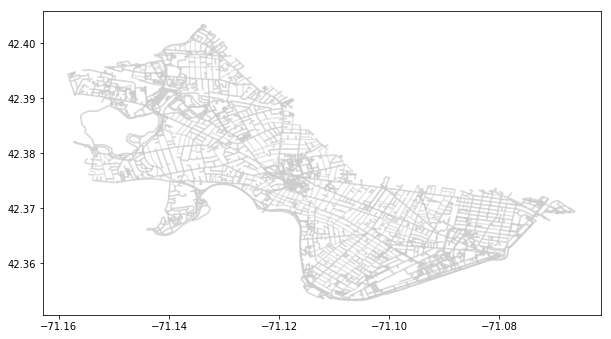

In [5]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.5)

Let's say you wanted to do a ice cream crawl: you want to visit every ice cream shop in a city. What is the shortest route that you would take that takes you to every ice cream shop in a city and brings you back to your starting point?

In [6]:
place_ice_cream = ox.pois_from_place(place_name, amenities=['bar'])
place_ice_cream

,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,amenity,drink:wine,ele,element_type,geometry,name,opening_hours,osmid,outdoor_seating,phone,smoking,url,website,wheelchair,building,gay,lgbtq,nodes,postal_code
981484250,Cambridge,738,02139,NaN,Massachusetts Avenue,bar,NaN,NaN,node,POINT (-71.1052914 42.366126),Cantab Lounge,NaN,981484250,NaN,NaN,NaN,http://www.cantab-lounge.com/,NaN,limited,NaN,NaN,NaN,NaN,NaN
1907895917,Cambridge,90,02142,MA,Broadway,bar,NaN,NaN,node,POINT (-71.08732929999999 42.363702),Mead Hall,"Mo-Sa 11:30-01:00, Su 15:00-24:00",1907895917,no,+1 617 714 4372,NaN,NaN,https://themeadhall.com/,no,NaN,NaN,NaN,NaN,NaN
2130009488,NaN,567,02139,NaN,Massachusetts Avenue,bar,NaN,NaN,node,POINT (-71.10245930000001 42.3648573),Brick & Mortar,NaN,2130009488,NaN,NaN,NaN,NaN,https://www.brickandmortarbar.com/,NaN,NaN,NaN,NaN,NaN,NaN
2700809528,Boston,149,02114,NaN,Charles Street,bar,NaN,NaN,node,POINT (-71.0706857 42.360447),Beacon Hill Pub,NaN,2700809528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2707976359,Cambridge,795,02139,NaN,Main Street,bar,NaN,NaN,node,POINT (-71.09712740000001 42.3633583),Cuchi Cuchi,NaN,2707976359,NaN,NaN,NaN,NaN,https://cuchicuchi.cc/,NaN,NaN,NaN,NaN,NaN,NaN
2966948876,Somerville,3,02143,NaN,Beacon Street,bar,NaN,NaN,node,POINT (-71.1015002 42.3744435),Parlor Sports,Mo-Fr 18:00-01:00; Sa-Su 00:00-01:00,2966948876,NaN,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3067171278,Somerville,NaN,NaN,NaN,Sanborn Court,bar,NaN,NaN,node,POINT (-71.0943561 42.3799556),Backbar,NaN,3067171278,NaN,NaN,NaN,NaN,https://backbarunion.com/,NaN,NaN,NaN,NaN,NaN,NaN
3445709783,Allston,116,02134,MA,Brighton Avenue,bar,NaN,NaN,node,POINT (-71.1307542 42.3526314),The White Horse,11:30-2:00,3445709783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3772735572,NaN,NaN,NaN,NaN,NaN,bar,NaN,NaN,node,POINT (-71.0862671 42.3890185),Casey's,NaN,3772735572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4267278518,NaN,NaN,NaN,NaN,NaN,bar,NaN,NaN,node,POINT (-71.12289440000001 42.372203),Regattabar,NaN,4267278518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
place_ice_cream['geometry'] = place_ice_cream.centroid  

In [8]:
ice_cream_nodes = ox.get_nearest_nodes(place_roads, place_ice_cream.geometry.x, place_ice_cream.geometry.y)
ice_cream_nodes

array([  61327348, 6264380257,   61327180, 3024196130,   61327113,
         61325478,   61321641, 3687653201,   61325597,   61329191,
         61329191,   61324660, 2691916176, 2691916176, 2691916176,
         61324660, 3687653201,   61323047, 5493351702,   61325553,
         61327517,   61324864, 5458830470,   61326119])

## Exercise
Plot the locations of the ice cream shops on the map of the roads

In [0]:
cambridge_bounds = Polygon.from_bounds(*place_roads_edges.total_bounds)

In [0]:
cambridge_bounds = cambridge_bounds.buffer(.001)

In [11]:
print(cambridge_bounds)

POLYGON ((-71.15834 42.3521829, -71.15843801714033 42.35218771527333, -71.158535090322 42.3522021147196, -71.15863028467724 42.35222595966427, -71.15872268343236 42.35225902046749, -71.15881139673682 42.35230097873565, -71.15889557023301 42.3523514303877, -71.15897439328415 42.35240988954664, -71.15904710678119 42.35247579321882, -71.15911301045335 42.35254850671583, -71.1591714696123 42.35262732976698, -71.15922192126435 42.35271150326317, -71.1592638795325 42.35280021656764, -71.15929694033572 42.35289261532274, -71.1593207852804 42.35298780967798, -71.15933518472667 42.35308488285967, -71.15934 42.3531829, -71.15934 42.4034663, -71.15933518472667 42.40356431714033, -71.1593207852804 42.40366139032201, -71.15929694033572 42.40375658467725, -71.1592638795325 42.40384898343236, -71.15922192126435 42.40393769673683, -71.1591714696123 42.40402187023302, -71.15911301045335 42.40410069328416, -71.15904710678119 42.40417340678118, -71.15897439328415 42.40423931045336, -71.15889557023301 42.

In [0]:
place_roads = ox.graph_from_polygon(cambridge_bounds)


In [0]:
place_roads_nodes,place_roads_edges = ox.graph_to_gdfs(place_roads)

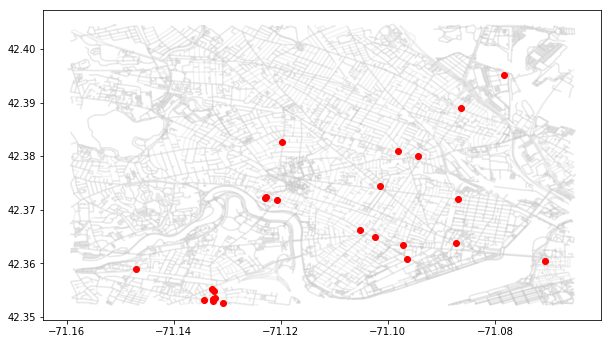

In [14]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=[0.8, 0.8, 0.8], alpha=0.25)
place_ice_cream.plot(ax=ax, color=['red'], alpha=1, zorder = 10)

## Compute shortest path matrix

In [15]:
shortest_path_matrix = np.zeros([len(ice_cream_nodes),len(ice_cream_nodes)])
for idx_i, orig in enumerate(ice_cream_nodes):
  for idx_j, dest in enumerate(ice_cream_nodes):
    shortest_path_matrix[idx_i, idx_j] = nx.shortest_path_length(place_roads, orig, dest, weight='length')
shortest_path_matrix

array([[   0.   , 1719.656,  298.542, 2737.911,  774.51 , 1238.493,
        1524.361, 1628.649, 1820.878, 1838.965, 1838.965, 4350.963,
        1734.45 , 1734.45 , 1734.45 , 4350.963, 1628.649, 2081.345,
        3096.296, 1922.225, 2428.114, 1263.754, 1027.027, 4188.517],
       [1714.042,    0.   , 1415.5  , 1140.868,  937.117, 1881.401,
        1741.774, 2910.736, 1801.708, 3553.007, 3553.007, 6065.005,
        3025.541, 3025.541, 3025.541, 6065.005, 2910.736, 1271.893,
        1721.81 , 3636.267, 3897.446, 1837.626,  928.002, 5837.27 ],
       [ 298.542, 1421.114,    0.   , 2439.369,  475.968, 1309.57 ,
        1526.402, 1600.911, 1781.25 , 2137.507, 2137.507, 4649.505,
        1706.712, 1706.712, 1706.712, 4649.505, 1600.911, 2030.648,
        3020.311, 2220.767, 2726.656, 1265.795,  728.485, 4421.77 ],
       [2734.254, 1154.199, 2435.712,    0.   , 1957.329, 2808.412,
        2480.76 , 3788.693, 2267.274, 4521.955, 4521.955, 7031.538,
        3903.498, 3903.498, 3903.498, 7031.53

In [0]:
ice_cream_graph = nx.from_numpy_matrix(shortest_path_matrix, create_using=nx.MultiDiGraph)

In [17]:
# new graph indexes from 0
ice_cream_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23))

In [18]:
# rename node labels using original labels
ice_cream_graph = nx.relabel_nodes(ice_cream_graph,{k:v for k, v in zip(ice_cream_graph.nodes, ice_cream_nodes)})
ice_cream_graph.nodes

NodeView((61327348, 6264380257, 61327180, 3024196130, 61327113, 61325478, 61321641, 3687653201, 61325597, 61329191, 61324660, 2691916176, 61323047, 5493351702, 61325553, 61327517, 61324864, 5458830470, 61326119))

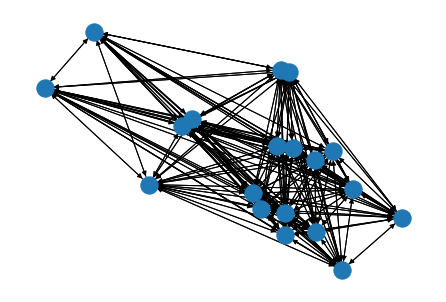

In [19]:
nx.draw_kamada_kawai(ice_cream_graph)

## Exercise
Find the best TSP path you can

In [41]:
totaldistance = 0
nodeslist = []
nodeslist.append(0)
for node in shortest_path_matrix:
  count = 0
  value = 0
  for short in node:
    if count == 0:
      min = short
    if short == 0:
      continue 
    elif short < min and count not in nodeslist and short != 0:
      value = count
      min = short   
    count+=1
  print(value)
  totaldistance+=min
  if value not in nodeslist:
    nodeslist.append(value)
  node = node[value:]
nodeslist


1
21
0
17
2
20
7
11
6
18
0
9
13
0
0
10
12
8
3
19
5
0
4
15


[0, 1, 21, 17, 2, 20, 7, 11, 6, 18, 9, 13, 10, 12, 8, 3, 19, 5, 4, 15]